# GRGL Library Introduction

GRGL is a library for constructing and traversing Genotype Representation Graphs (GRGs). This notebook gives a brief introduction to the APIs and use-cases for GRGL.

In [1]:
from pygrgl import GRG, grg_from_trees
from pygrgl.display import grg_to_cyto
import tskit
import io
from IPython.display import display, SVG

GRGs can be constructed in one of three ways:
1. By converting a [tskit tree sequence](https://tskit.dev/tutorials/what_is.html#sec-what-is) to a GRG. This is done by loading a .trees file from disk (converting an in-memory tree-seq is not currently possible). This is typically a fast operation; it may take only a few minutes even for very large tree sequences.
2. By inferring a GRG from a raw dataset. This can be done from a [VCF file]() or an [IGD file](). We recommend converting VCF to IGD first if the dataset is large, as this saves significant time. Inferring a GRG can use parallel threads and uses a fair amount of memory.
3. By constructing one from a set of edge lists, and then attaching mutations to a subset of the nodes.

This notebook creates a GRG from a tree-sequence, as that is the simplest way to start.

### Make a simple tree sequence

Just to illustrate the GRG construction.

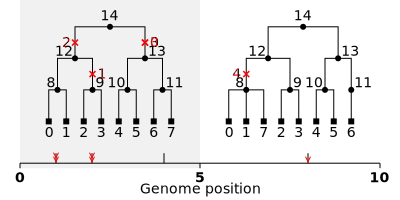

In [2]:
nodes = """\
is_sample   individual   time
1           -1           0.0
1           -1           0.0
1           -1           0.0
1           -1           0.0
1           -1           0.0
1           -1           0.0
1           -1           0.0
1           -1           0.0
0           -1           1.0
0           -1           1.0
0           -1           1.0
0           -1           1.0
0           -1           2.0
0           -1           2.0
0           -1           3.0
"""
edges = """\
left   right   parent  child
0.0    10.0    8       0
0.0    10.0    8       1
0.0    10.0    9       2
0.0    10.0    9       3
0.0    10.0    10      4
0.0    10.0    10      5
0.0    10.0    11      6
0.0     5.0    11      7
5.0    10.0    8       7
0.0    10.0    12      8
0.0    10.0    12      9
0.0    10.0    13      10
0.0    10.0    13      11
0.0    10.0    14      13
0.0    10.0    14      12
"""
sites = """\
position      ancestral_state
1.0           A
2.0           A
4.0           A
8.0           A
"""
mutations = """\
site   node    derived_state    time    parent
1      12      G                2.5     -1
3      8       G                1.5     -1
1      13      C                2.5     -1
0      13      T                2.5     -1
0      9       G                1.5     -1
"""

ts = tskit.load_text(
    nodes=io.StringIO(nodes),
    edges=io.StringIO(edges),
    sites=io.StringIO(sites),
    mutations=io.StringIO(mutations),
    strict=False
)
TREE_FILENAME = "simple_example.trees"
ts.dump(TREE_FILENAME)
display(SVG(ts.draw_svg()))

### Create the GRG from tree-seq

The GRG corresponding to the above tree-sequence contains a node for each of the 5 mutations, and a node for each of the 8 samples. During construction, the GRG makes use of all of the nodes from the original ARG (tree-sequence representation), so you'll see all of those nodes below **except** for node `14` which is not reachable from any mutations.

In [3]:
g = grg_from_trees(TREE_FILENAME)
display(grg_to_cyto(g))

CytoscapeWidget(cytoscape_layout={'name': 'dagre'}, cytoscape_style=[{'selector': 'node', 'style': {'font-fami…

### Save and simplify GRG

We can now save the GRG file which will cause it to be simplified -- that is, any extraneous nodes/edges will be removed. The nodes will also be renumbered for better performance.

In [4]:
from pygrgl import save_grg
GRG_FILENAME = "simple_example.grg"
save_grg(g, GRG_FILENAME)

(12, 12)

# Reload and compute against the GRG

We could have just done computations directly against the GRG that we constructed from the tree-sequence. However you can see below that the one we loaded is smaller. For really large datasets, this can make a big difference.

There are two forms of GRG: mutable and immutable. Immutable GRGs are only available after deserializing a GRG from disk, and they offer some performance improvements (both CPU time and RAM usage). If you are doing computations, you almost certainly want an immutable GRG.

In [5]:
from pygrgl import load_immutable_grg
g = load_immutable_grg(GRG_FILENAME)
display(grg_to_cyto(g))

CytoscapeWidget(cytoscape_layout={'name': 'dagre'}, cytoscape_style=[{'selector': 'node', 'style': {'font-fami…

### Allele Frequency

Below we caclulate the allele frequency. This calculation can be done very quickly from much simpler file formats than GRG, but it serves as a nice example.

In [6]:
from pygrgl import get_dfs_order, TraversalDirection

node_sample_counts = {}
for node_id in get_dfs_order(g, TraversalDirection.DOWN, g.get_root_nodes()):
    count = 1 if g.is_sample(node_id) else 0
    for child_id in g.get_down_edges(node_id):
        count += node_sample_counts[child_id]
    node_sample_counts[node_id] = count

for node_id, mutation_id in g.get_node_mutation_pairs():
    mutation = g.get_mutation_by_id(mutation_id)
    count = node_sample_counts[node_id]
    print(f"Mutation({mutation_id}): ({mutation.position}, {mutation.allele}) has sample count {count}")

Mutation(4): (8, G) has sample count 3
Mutation(0): (1, G) has sample count 2
Mutation(3): (2, G) has sample count 4
Mutation(1): (1, T) has sample count 4
Mutation(2): (2, C) has sample count 4


### Even faster

Above we traversed the entire graph, because we started at the list of roots (`g.get_root_nodes()`) and traversed down. The above traversal functions are very flexible, and you usually want to use them when you only want to traverse a _subset_ of the graph: for example, the DFS uses a stack to track your progress through the graph from a specific set of seed nodes (the roots, above).

The immutable GRG has the property that NodeIDs are already renumbered for bottom-up traversal (like the DFS above), so whenever you are traversing the entire graph you can just iterate in NodeID order, like below.

In [ ]:
node_sample_counts = {}
for node_id in range(0, g.num_nodes):
    count = 1 if g.is_sample(node_id) else 0
    for child_id in g.get_down_edges(node_id):
        count += node_sample_counts[child_id]
    node_sample_counts[node_id] = count

for node_id, mutation_id in g.get_node_mutation_pairs():
    mutation = g.get_mutation_by_id(mutation_id)
    count = node_sample_counts[node_id]
    print(f"Mutation({mutation_id}): ({mutation.position}, {mutation.allele}) has sample count {count}")